In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

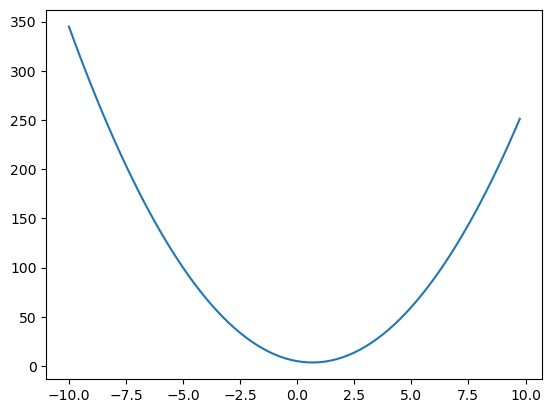

In [4]:
xs = np.arange(-10,10,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [58]:
class Value:
    
    def __init__(self, data, _children=(), _op="",label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self.label = label
        self._op = _op
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += (other.data)*(out.grad)
            other.grad += (self.data)*(out.grad)
        out._backward = _backward    
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/floadt for now"
        out = Value(self.data**other,(self,), f'**{other}')
        
        def _backward():
            self.grad = other * (self.data ** (other - 1))*out.grad
        out._backward = _backward
        return out 
                    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh', 'o')
        
        def _backward():
            self.grad += (1 - t**2)*(out.grad)
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        # Topological Sort to know the order of execution
        self.grad = 1
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
                   
        for node in reversed(topo):
            node._backward()
                
    
    
a = Value(2.0, label='a')
b = Value(3.0,label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
f = Value(-2.0, label='f')
d = e + c; d.label = 'd'
L = f*d ; L.label = 'L'    

In [6]:
d._prev

{Value(data=10.0), Value(data=6.0)}

In [7]:
d._op

'+'

In [8]:
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) # LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular {'record'} node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [9]:
L.backward()

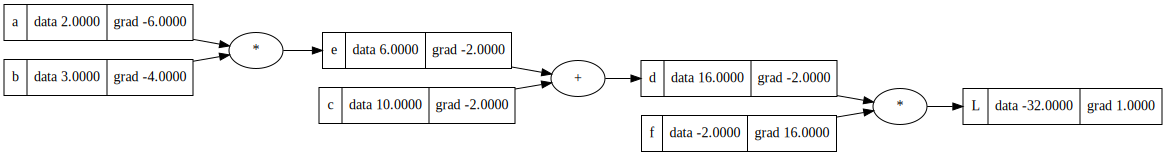

In [10]:
draw_dot(L)

In [11]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    f = Value(-2.0, label='f')
    d = e + c; d.label = 'd'
    L = f*d
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    f = Value(-2.0, label='f')
    d = e + c; d.label = 'd'
    L = f*d
    L2 = L.data
    
    print((L2 - L1)/h)
lol()

6.000000000021544


In [12]:
# Implementation of backprop on neuron 

# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh()


#------------- instead of tanh()
# e = (2*n).exp()
# o = (e - 1)/(e + 1)
#-----------
o.label = 'o'
o.backward()

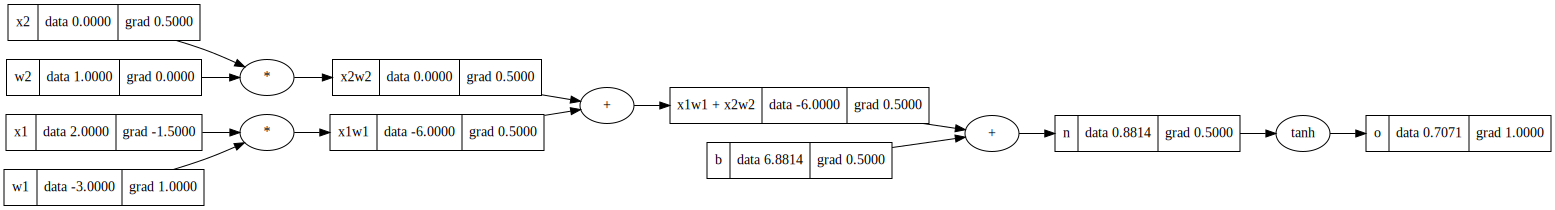

In [13]:
draw_dot(o)

In [14]:
o.grad = 1.0  # do/do

In [15]:
# o = tan(n)
# do/dn = 1 - tan(n)**2

n.grad = 1 - o.data**2

# + distrubute the grade 
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad


# do/dw1 = (dx1w1/dw1)*(do/dx1w1)

w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad

In [16]:

o.backward()


In [17]:
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

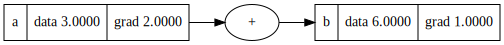

In [18]:
#bug 
a = Value(3.0,label ='a')
b = a + a ; b.label = 'b'

b.backward()
draw_dot(b) # db/da should be 2 

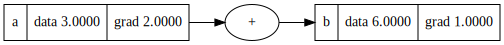

In [19]:
#bug : Solution accumlate the grads
a = Value(3.0,label ='a')
b = a + a ; b.label = 'b'

b.backward()
draw_dot(b) # db/da should be 2 

In [20]:
a.exp()

Value(data=20.085536923187668)

In [21]:
a - b

Value(data=-3.0)

In [22]:
# Implementation of the same in pytorch

import torch

In [23]:
x1 = torch.Tensor([2.0]).double() ;                 x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ;                 x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ;                 w2.requires_grad = True
b = torch.Tensor([6.8813735878195432]).double() ;   b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-------------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [24]:
import random 

In [374]:

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x): # n(x)
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs  
    
    def parameters(self):
        params  = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
                       
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [414]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.7981963227146615)

In [415]:
xs = [
    [3.0, 3.0 , -2.0],
    [4.0, -1.0 , 0.5],
    [1.5, -1.0 , 1.0],
    [1.0, 1.0 , -1.0],
]
ys  =[1.0 , -1.0 , 1.0, -1.0]

In [456]:

for k in range(100):
    
    # forward pass 
    y_pred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
    
    # backward prop
    for p in n.parameters(): # zero grad
        p.grad = 0.0
    loss.backward()
    
    # grad descent 
    for p in n.parameters():
        p.data += -(0.01) * p.grad
    
    print(k, loss.data)
      

  

0 0.001289947126641665
1 0.0012896073634590447
2 0.0012892677720628258
3 0.0012889283523247472
4 0.0012885891041166978
5 0.001288250027310696
6 0.0012879111217789004
7 0.0012875723873935678
8 0.0012872338240270868
9 0.0012868954315519913
10 0.0012865572098409272
11 0.0012862191587666516
12 0.0012858812782020794
13 0.0012855435680202306
14 0.0012852060280942382
15 0.0012848686582973886
16 0.001284531458503067
17 0.0012841944285848055
18 0.001283857568416251
19 0.0012835208778711662
20 0.0012831843568234518
21 0.0012828480051471094
22 0.0012825118227163053
23 0.0012821758094052923
24 0.0012818399650884544
25 0.0012815042896403143
26 0.0012811687829354951
27 0.0012808334448487747
28 0.001280498275255015
29 0.0012801632740292307
30 0.001279828441046544
31 0.0012794937761822036
32 0.0012791592793115812
33 0.0012788249503101797
34 0.0012784907890535976
35 0.0012781567954175792
36 0.0012778229692779802
37 0.0012774893105107932
38 0.0012771558189921123
39 0.0012768224945981534
40 0.00127648933

In [455]:
y_pred

[Value(data=0.9795370664017738),
 Value(data=-0.9812693381661386),
 Value(data=0.9824389908572893),
 Value(data=-0.985428497831426)]

In [419]:
n.layers[0].neurons[0].w[0].grad

-0.0018411548497385957

In [367]:
for p in n.parameters():
    p.data += -(0.01) * p.grad

In [368]:
y_pred

[Value(data=0.9909418428507513),
 Value(data=-0.9999428333502574),
 Value(data=0.9949734483787127),
 Value(data=-0.9999793400702681)]

In [369]:
n.parameters()

[Value(data=-0.688077561775794),
 Value(data=2.417527756065466),
 Value(data=3.3632454886218195),
 Value(data=-0.35794631359053447),
 Value(data=-0.3229158217059971),
 Value(data=-0.5939616315099898),
 Value(data=-0.4398820884666352),
 Value(data=-0.3927987555706736),
 Value(data=-1.761957147300391),
 Value(data=0.01962264381799193),
 Value(data=0.5310861561745688),
 Value(data=-0.8393256993102549),
 Value(data=0.5870137288845734),
 Value(data=-0.3829319287649398),
 Value(data=0.561596278468553),
 Value(data=0.4538159550894414),
 Value(data=-0.7484470297074906),
 Value(data=-1.0072126141272966),
 Value(data=-0.3769682632544064),
 Value(data=0.5631569234930315),
 Value(data=0.9494783649490348),
 Value(data=-1.7765821624737406),
 Value(data=1.0757575696491144),
 Value(data=-1.0729525949690029),
 Value(data=-0.7863927645924624),
 Value(data=-0.17513491492876293),
 Value(data=1.2166886029060533),
 Value(data=0.5445896850374501),
 Value(data=0.4003259710288287),
 Value(data=-0.5705196614963